In [1]:
import sys
sys.path.insert(0, "/cndd/fangming/CEMBA/snmcseq_dev")

from multiprocessing import Pool,cpu_count
from functools import partial

from scipy import sparse
import importlib
from __init__ import *
from __init__jupyterlab import *
import snmcseq_utils
importlib.reload(snmcseq_utils)

import pickle
import datetime

- read enhancer-cell-matrix (mcg)
- read gene-cell matrix (rna)
- read kNN matrix (from previous files)
- read enhancer-gene linkage files (from previous files)

- do the analysis

# Todo

- figure out the best matrix multiplications to do

- make sure the enhancer-gene linkage file match

In [2]:
today = datetime.date.today()
print(today)

2020-07-28


# correlate enhancer and gene (a new notebook)

In [3]:
# load from file

# save ec_mccg and gc_rna
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/ec_mccg_test1.pkl'
with open(f, 'rb') as fh:
    ec_mccg = pickle.load(fh)
print(time.time()-ti)
    
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/gc_rna_test1.pkl'
with open(f, 'rb') as fh:
    gc_rna = pickle.load(fh).todense()
print(time.time()-ti)

print(ec_mccg.shape, gc_rna.shape)

21.861902713775635
8.5902681350708
(87943, 6244) (32324, 6244)


In [4]:
# gene-cell matrix (rna)

ti = time.time()
f = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.npz'
fgene = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.gene'
fcell = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/smarter_cells_features.cell'

gene_cell_rna_mat = snmcseq_utils.load_gc_matrix(fgene, fcell, f)

print(gene_cell_rna_mat.data.shape)
print(time.time()-ti)


(32324, 6244)
24.63028907775879


In [5]:
# enhancer-gene linkage
ti = time.time()
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals.tsv'
enhancer_gene_to_eval = pd.read_csv(f, sep='\t')
f = '/cndd2/fangming/projects/scf_enhancers/results/200521_to_evals_shuffled.tsv'
enhancer_gene_to_eval_shuffled = pd.read_csv(f, sep='\t')

print(enhancer_gene_to_eval.shape)
print(time.time()-ti)
enhancer_gene_to_eval.head()

(2589994, 18)
8.907484292984009


,gene,ens,val,val2,val_clustershuffled,val2_clustershuffled,dist,pvalues,fdr<100kb,fdr<200kb,fdr<500kb,fdr<100kb shuffled (cluster label),pvalues2,fdr2<100kb,fdr2<200kb,fdr2<500kb,fdr2<100kb shuffled (cluster label),val_both
0,ENSMUSG00000000001,147520,-0.157895,0.127913,-0.169712,-0.049349,995118,0.288079,0.674683,0.736811,0.827139,1.647931,0.383141,0.745977,0.797076,0.872822,1.955898,-0.285808
1,ENSMUSG00000000001,147522,0.027465,-0.307145,0.064887,0.105591,985740,0.561881,0.830849,0.867082,0.917381,0.958300,0.935264,0.973809,0.979844,0.987476,0.959470,0.334610
2,ENSMUSG00000000001,147523,-0.040376,0.011489,-0.155487,0.014772,983725,0.457686,0.780196,0.825259,0.889141,1.089312,0.580703,0.841673,0.874844,0.922832,1.273339,-0.051866
3,ENSMUSG00000000001,147527,-0.070795,0.111719,-0.088084,0.184594,970444,0.411564,0.755088,0.804341,0.874375,1.183332,0.410358,0.761056,0.809464,0.880982,1.812516,-0.182514
4,ENSMUSG00000000001,147528,0.012583,0.150673,-0.036218,0.147609,969372,0.539123,0.819981,0.858026,0.911467,0.979843,0.345993,0.725803,0.780447,0.862033,2.191506,-0.138090


In [8]:

gene_idx = snmcseq_utils.get_index_from_array(gene_cell_rna_mat.gene, enhancer_gene_to_eval['gene'])
enh_idx = snmcseq_utils.get_index_from_array(ec_mccg.index.values, enhancer_gene_to_eval['ens']) # be careful here!

to_correlate = ~np.logical_or(gene_idx==-1, enh_idx==-1)

In [16]:
# enhancer_gene_to_eval[((enhancer_gene_to_eval['dist'] < 100000) & (to_correlate))]


array([985740, 969372, 931364, ..., 242242, 294607, 972679])

2067 999999


# plotting results
- different k

In [24]:
f = '/cndd2/fangming/projects/scf_enhancers/results/2020-07-28_corrs_test1.pkl'
with open(f, 'rb') as fh:
    corrs, corrs_shuffled = pickle.load(fh)

In [50]:
print(len(corrs))

1543535


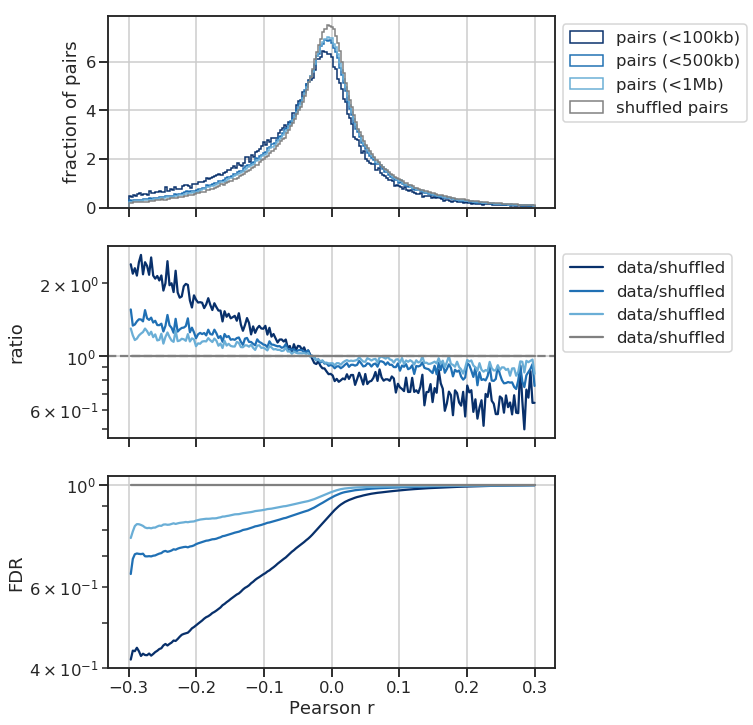

In [70]:
config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}

num_bins = 200
bins = np.linspace(-0.3, 0.3, num_bins)

colors = snmcseq_utils.get_grad_colors(5, cmap='Blues_r')
tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
    }
track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
    }


tracks_hist_ratios = {}
track_cdfs = {}
fdr_cdfs = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
for label, track in tracks.items():
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    fdr = cdf_shuff/cdf
    tracks_hist_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    fdr_cdfs[label] = fdr


fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')

ax = axs[1]
for label, track in tracks_hist_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.axhline(1, linestyle='--', color='gray')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('ratio')

ax = axs[2]
for label, track in fdr_cdfs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')

output = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v1.pdf'.format(today)
plt.show()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: invalid value encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in true_divide
/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


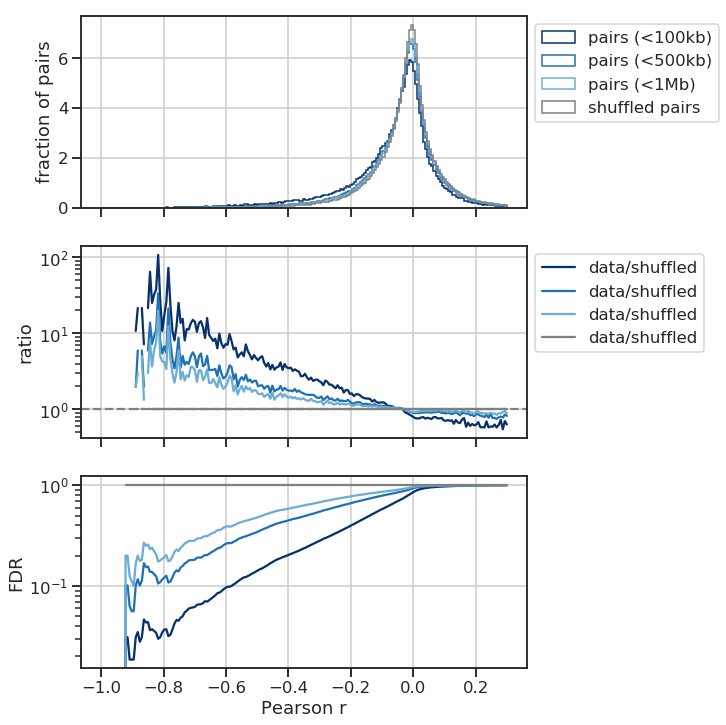

In [71]:
config = {
    'kde': False,
    "hist_kws": {
                'histtype': 'step', 
#                 'edgecolor': 'none',
                'alpha': 1, 
                'density': True, 
                },
}

num_bins = 200
bins = np.linspace(-1, 0.3, num_bins)

colors = snmcseq_utils.get_grad_colors(5, cmap='Blues_r')
tracks = {
    'pairs (<100kb)': corrs[dists<1e5], 
    'pairs (<500kb)': corrs[dists<5e5], 
    'pairs (<1Mb)': corrs, 
    'shuffled pairs': corrs_shuffled, 
    }
track_colors = {
    'pairs (<100kb)': colors[0], 
    'pairs (<500kb)': colors[1], 
    'pairs (<1Mb)': colors[2], 
    'shuffled pairs': 'gray', 
    }


tracks_hist_ratios = {}
track_cdfs = {}
fdr_cdfs = {}

hist_shuff, _ = np.histogram(corrs_shuffled, bins=bins, normed=True)
cdf_shuff = np.cumsum(hist_shuff)
for label, track in tracks.items():
    hist, _ = np.histogram(track, bins=bins, normed=True)
    cdf = np.cumsum(hist)
    fdr = cdf_shuff/cdf
    tracks_hist_ratios[label] = hist/hist_shuff
    track_cdfs[label] = cdf 
    fdr_cdfs[label] = fdr


fig, axs = plt.subplots(3, 1, figsize=(4*2,4*3), sharex=True)

ax = axs[0]
for label, track in tracks.items():
    sns.distplot(track, bins=bins, ax=ax, label=label, color=track_colors[label], **config)
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('fraction of pairs')

ax = axs[1]
for label, track in tracks_hist_ratios.items():
    ax.plot(bins[1:], track, label="data/shuffled", color=track_colors[label])
ax.set_yscale('log')
ax.axhline(1, linestyle='--', color='gray')
ax.legend(bbox_to_anchor=(1,1), loc='upper left')
ax.set_ylabel('ratio')

ax = axs[2]
for label, track in fdr_cdfs.items():
    ax.plot(bins[1:], track, color=track_colors[label])
ax.set_yscale('log')
ax.set_ylabel('FDR')
ax.set_xlabel('Pearson r')

output = '/cndd2/fangming/projects/scf_enhancers/results/figures/{}_cell_level_mc_rna_corr_v2.pdf'.format(today)
plt.show()